### Look at Belief State Value CCGP, during Feedback Onset

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
import seaborn as sns

import scipy


In [3]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
matplotlib.rcParams.update({'font.size': 12})


In [4]:
pairs = pd.read_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_7sess.pickle")
# pairs = pd.read_pickle("/data/patrick_res/sessions/BL/pairs_at_least_1blocks_3sess.pickle")
pairs = pairs.reset_index(drop=True)

In [5]:
regions = ["temporal", "anterior", None]
conds = ["within_cond", "across_cond", "overall"]

res = []
for region in regions: 
    for cond in conds:  
        for use_next_trial_value in [True, False]: 
            for (feat1, feat2) in pairs.pair.values:
                region_str = "" if region is None else f"_{region}"
                next_trial_str = "_next_trial_value" if use_next_trial_value else ""

                acc = np.load(os.path.join(OUTPUT_DIR, f"SA_ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}{region_str}{next_trial_str}_{cond}_accs.npy"))
                df = pd.DataFrame(acc).reset_index(names=["Time"])
                df["Time"] = (df["Time"] * INTERVAL_SIZE + INTERVAL_SIZE - PRE_INTERVAL) / 1000
                df = df.melt(id_vars="Time", value_vars=list(range(acc.shape[1])), var_name="run", value_name="Accuracy")
                # df["pair"] = feat1, feat2
                df["region"] = region
                df["condition"] = cond
                df["use_next_trial_value"] = use_next_trial_value
                res.append(df)
res = pd.concat(res)

### Overall difference between next trial value and current trial

Text(0.5, 1.0, 'overall difference between next trial value and current trial')

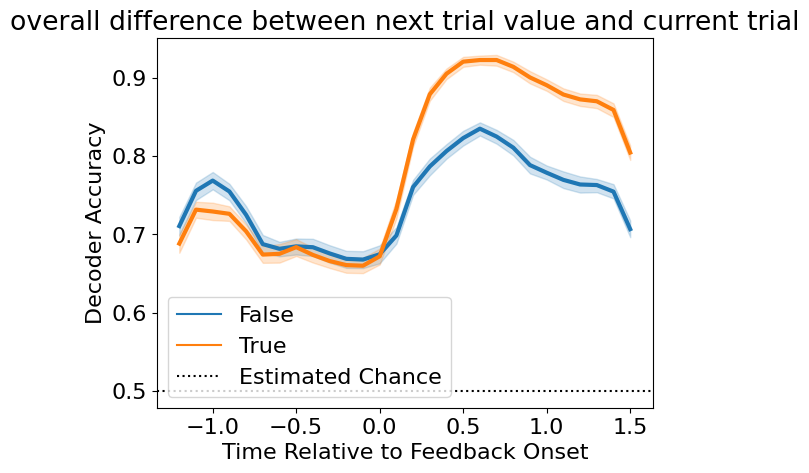

In [17]:
fig, ax = plt.subplots()
overalls = res[(res.condition == "overall") & (res.region.isna())]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="use_next_trial_value", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("overall difference between next trial value and current trial")

### Overall, prev vs. next trial

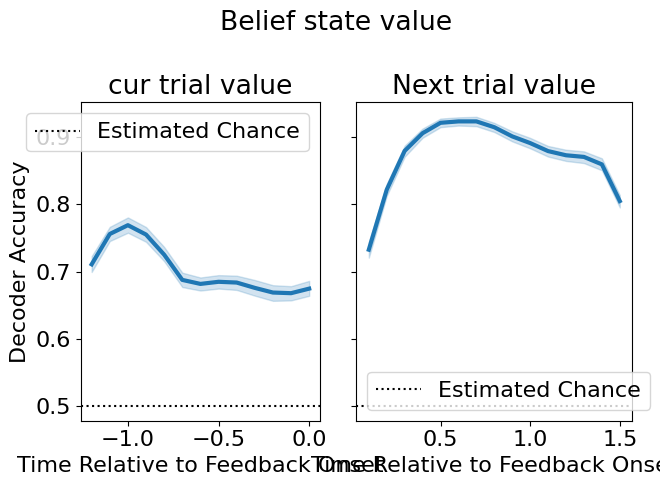

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls_pre_fb = res[(res.condition == "overall") & (~res.use_next_trial_value) & (res.Time <= 0) & (res.region.isna())]
sns.lineplot(overalls_pre_fb, x="Time", y="Accuracy", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls_post_fb = res[(res.condition == "overall") & (res.use_next_trial_value)& (res.Time > 0) & (res.region.isna())]
sns.lineplot(overalls_post_fb, x="Time", y="Accuracy", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("Next trial value")
fig.suptitle("Belief state value")
fig.tight_layout()


### Cross time decoding for overall, current trial value

Text(0, 0.5, 'Time Model Trained (s)')

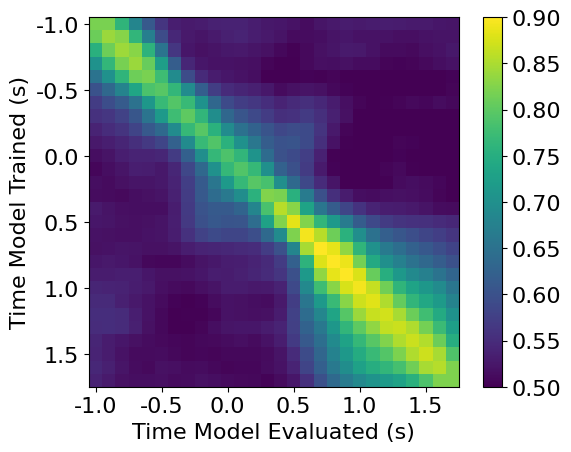

In [19]:
fig, ax = plt.subplots()
all_accs = []
for (feat1, feat2) in pairs.pair.values:
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"SA_ccgp_belief_state_value_FeedbackOnset_pair_{feat1}_{feat2}_overall_cross_accs.npy"))
    all_accs.append(cross_accs)
all_accs = np.concatenate(all_accs, axis=2)
all_accs = np.mean(all_accs, axis=2)
colors = ax.matshow(all_accs)
colors.set_clim(0.5, 0.9)
fig.colorbar(colors, ax=ax)
ratio = 1000 / 100
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
# tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_pos = (tick_labels + 1) * ratio
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
# ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axvline(9.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")

### Generate decoding plot for FADEx 2025

In [20]:
overalls_combined = pd.concat([overalls_pre_fb, overalls_post_fb])

In [21]:
overalls_combined

,Time,run,Accuracy,region,condition,use_next_trial_value
0,-1.2,0,0.6800,None,overall,False
1,-1.1,0,0.7600,None,overall,False
2,-1.0,0,0.7550,None,overall,False
3,-0.9,0,0.6800,None,overall,False
4,-0.8,0,0.7075,None,overall,False
...,...,...,...,...,...,...
219,1.1,7,0.8675,None,overall,True
220,1.2,7,0.9125,None,overall,True
221,1.3,7,0.8900,None,overall,True
222,1.4,7,0.8700,None,overall,True


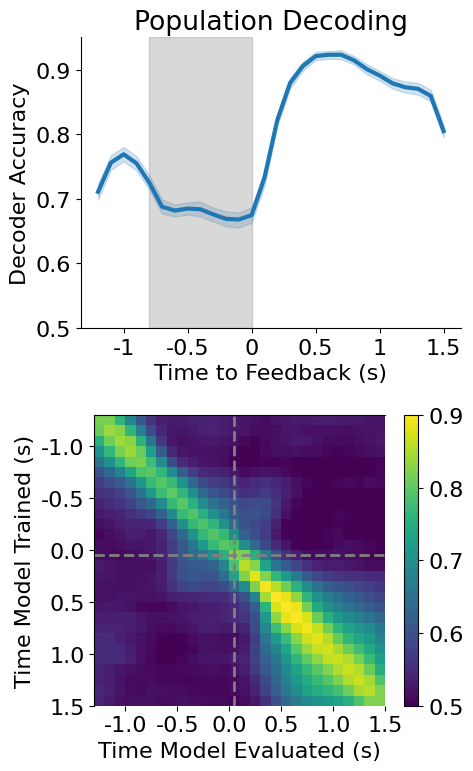

In [30]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
ax = axs[0]
sns.lineplot(overalls_combined, x="Time", y="Accuracy", linewidth=3, ax=ax)

# ax.legend()
# for line in ax.legend().get_lines():
#     line.set_linewidth(4)
# # add estimated chance
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time to Feedback (s)")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Population Decoding")
ax.set_xticks([-1, -.5, 0, .5, 1, 1.5])
ax.set_xticklabels([-1, -.5, 0, .5, 1, 1.5])
ax.set_ylim([0.5, .95])
ax.set_yticks([.5, .6, .7, .8, .9])
ax.set_yticklabels([.5, .6, .7, .8, .9])

# plt.rcParams.update({'font.size': 14})
ax = axs[1]
colors = ax.matshow(all_accs)
colors.set_clim(0.5, 0.9)
fig.colorbar(colors, ax=ax)
ratio = 1000 / 100
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
# tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_pos = (tick_labels + 1.3) * ratio - 0.5
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
# ax.axvline(4.5, color="gray", linestyle="dotted", linewidth=2)
# ax.axhline(4.5, color="gray", linestyle="dotted", linewidth=2)
ax.axvline(13, color="gray", linestyle="dashed", linewidth=2)
ax.axhline(13, color="gray", linestyle="dashed", linewidth=2)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")
ax.spines[['bottom', 'right']].set_visible(False)


fig.tight_layout()

fig.savefig("/data/patrick_res/figures/2025_fadex_poster/bsv_decoding_fbonset.svg")



### Temporal vs. Anterior, prev vs. next trial

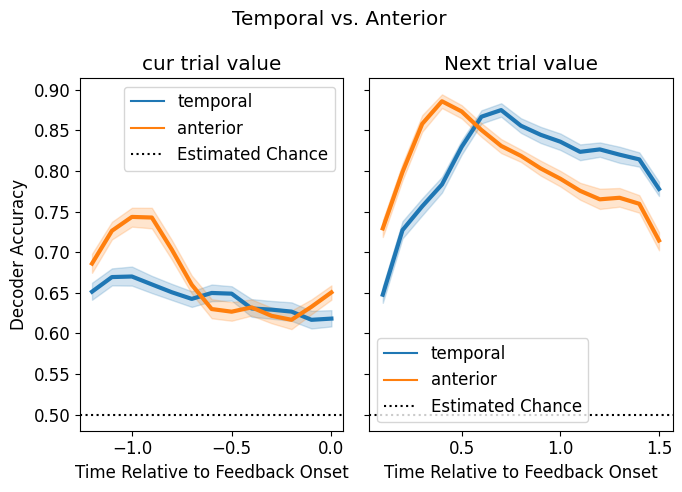

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(res.condition == "overall") & (~res.use_next_trial_value) & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="region", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.condition == "overall") & (res.use_next_trial_value)& (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="region", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("Next trial value")
fig.suptitle("Temporal vs. Anterior ")
fig.tight_layout()


### CCGP All regions

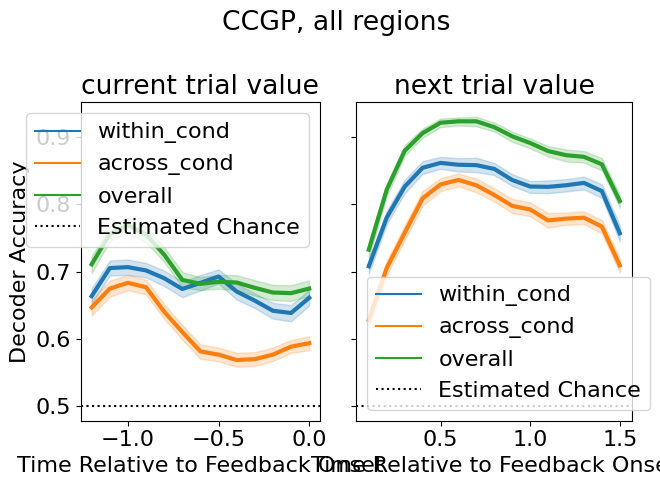

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
pre_fb = res[(~res.use_next_trial_value) & (res.region.isna()) & (res.Time <= 0)]
sns.lineplot(pre_fb, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("current trial value")

ax = axs[1]
post_fb = res[(res.use_next_trial_value) & (res.region.isna()) & (res.Time > 0)]
sns.lineplot(post_fb, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("next trial value")
fig.suptitle("CCGP, all regions")
fig.tight_layout()


### 2025 Fadex, CCGP Fig

In [25]:
combined = pd.concat([pre_fb, post_fb])
combined = combined[combined.condition != "overall"]

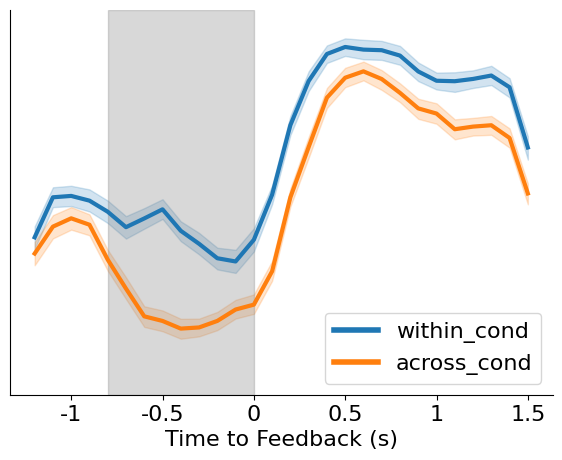

In [27]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(combined, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
ax.legend()
for line in ax.legend().get_lines():
    line.set_linewidth(4)
# ax.legend()
# for line in ax.legend().get_lines():
#     line.set_linewidth(4)
# # add estimated chance
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time to Feedback (s)")
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([-1, -.5, 0, .5, 1, 1.5])
ax.set_xticklabels([-1, -.5, 0, .5, 1, 1.5])
ax.set_ylim([0.5, 0.9])
ax.set_yticks([])
ax.set_ylabel("")
fig.savefig("/data/patrick_res/figures/2025_fadex_poster/ccgp_fbonset.svg")

# ax.set_yticklabels([.5, .6, .7, .8, .9])

### CCGP, diff regions

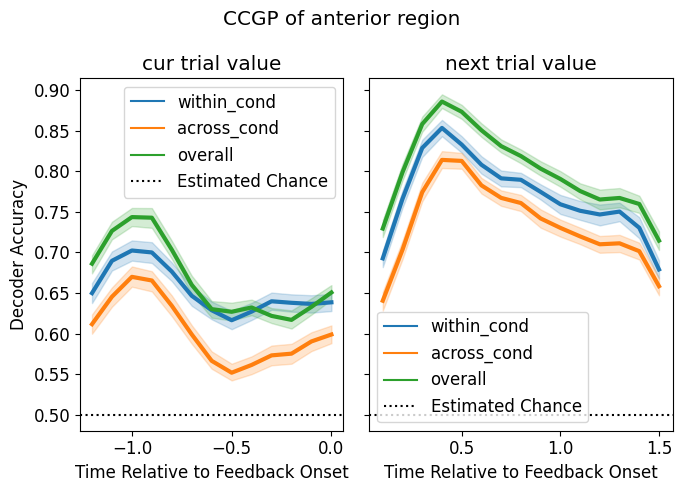

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(~res.use_next_trial_value) & (res.region == "anterior") & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.use_next_trial_value) & (res.region == "anterior") & (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("next trial value")
fig.suptitle("CCGP of anterior region")
fig.tight_layout()




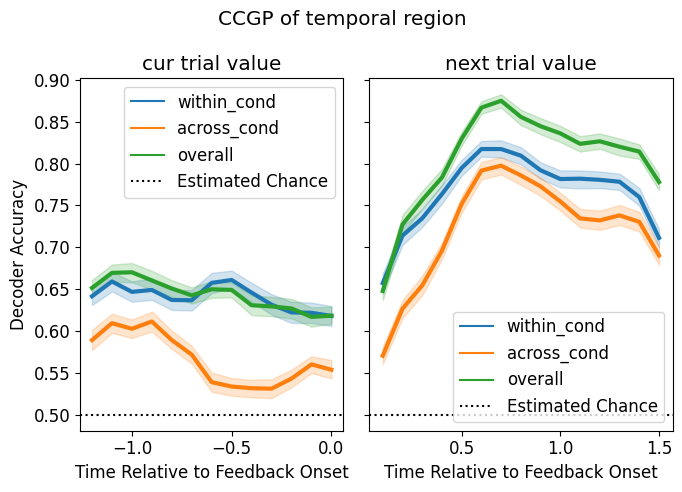

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(~res.use_next_trial_value) & (res.region == "temporal") & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.use_next_trial_value) & (res.region == "temporal") & (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("next trial value")
fig.suptitle("CCGP of temporal region")
fig.tight_layout()

